---
#documentclass: proc
title: Analysis of rank-score data for the TU Delft Aerospace Selection Process
author: erentar2002
date: 2023-04-15
date-format: "2023-04-15"
thanks: "Special thanks to Django van der Plas and everyone on the TU Delft Study server. If at any time the word \"we\" is used, it refers to my conversations with various people in the server."
abstract: "The exam scores on the TU Delft Aerospace Selection process are released a day before the ranks are. This day of waiting is usually extremely painful and to get around that, I have collected and compiled data from various discord and whatsapp channels to produce this document. I dont know what i am doing, so take it with a huge pinch of salt, and please do suggest better methodology. Compiling this data will be only the simplest step we can take in understanding how the entrance process really works, as very little information about it is released to the public."
execute:
  echo: false
format: pdf
pdf-engine: pdflatex
fontfamily: mlmodern
papersize: a4
toc: true

---

Source: [https://github.com/erentar/tud-aero-selection-rankings](https://github.com/erentar/tud-aero-selection-rankings)

# Data for previous years

## Data collection
I went into all of the TU Delft discords i know of, searched for "rank". Clusters of messages around activity spikes (usually over a few days) included a lot of screenshots of scores with, ranks included. These were added to a spreadsheet `data.ods`, and used to create following plots.

## Analysis
Expected distribution would be a gaussian distribution.
Ranking each member would involve finding the percentile of every point on this gaussian distribution. Cumulative distribution function of the normal distribution would give percentile of every point.

The cumulative distribution function is equivalent to the indefinite integral of the gaussian distribution, which is known as the error function $\textrm{erf}$.

The scavenged data was already ranked, the expected fit would be an $\textrm{erf}$ fit.

To find the model below, sagemath is used.

```{sage}
var("a,b,c")
model(x) = a * ( erf(b*x)+1 )
fit1 = find_fit(year:list,model)
```

The full code can be inspected in the source of this document.

In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score

In [2]:
# hide warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')

In [4]:
sheet = pd.read_excel(
    "data.ods",
    sheet_name="Sheet1",
    header=int(0),
    usecols="A:J"
)

# remove the incomplete rows
sheet = sheet[sheet.has_data_complete != 0]

# remove the `average` rows because it trips up numpy in the fit section
sheet = sheet[sheet.person != "average"]

In [5]:
data = sheet[["distance from avg","rank"]].values

In [6]:
def year(year:int):
    return sheet[sheet["year"]==year][["distance from avg","rank"]].values

In [7]:
var("a,b,c")
model(x) = a * (erf(b*x)+1)

def print_model(fit:list) -> str:
    return(f"{round(fit[0].rhs(),5)}*(\\mathrm{'{erf}'}({round(fit[1].rhs(),5)}*x)+1)")

def fit_to_year(year:np.array):
    return find_fit(
        year.astype(float),
        model,
        initial_guess=[2000.0,-5.0],
        parameters=[a,b],
        variables=[x]
    )

In [8]:
current_data = np.concatenate([
    year(2019),
    year(2020),
    year(2021),
    year(2022)
])

In [9]:
old_fit = fit_to_year(current_data)

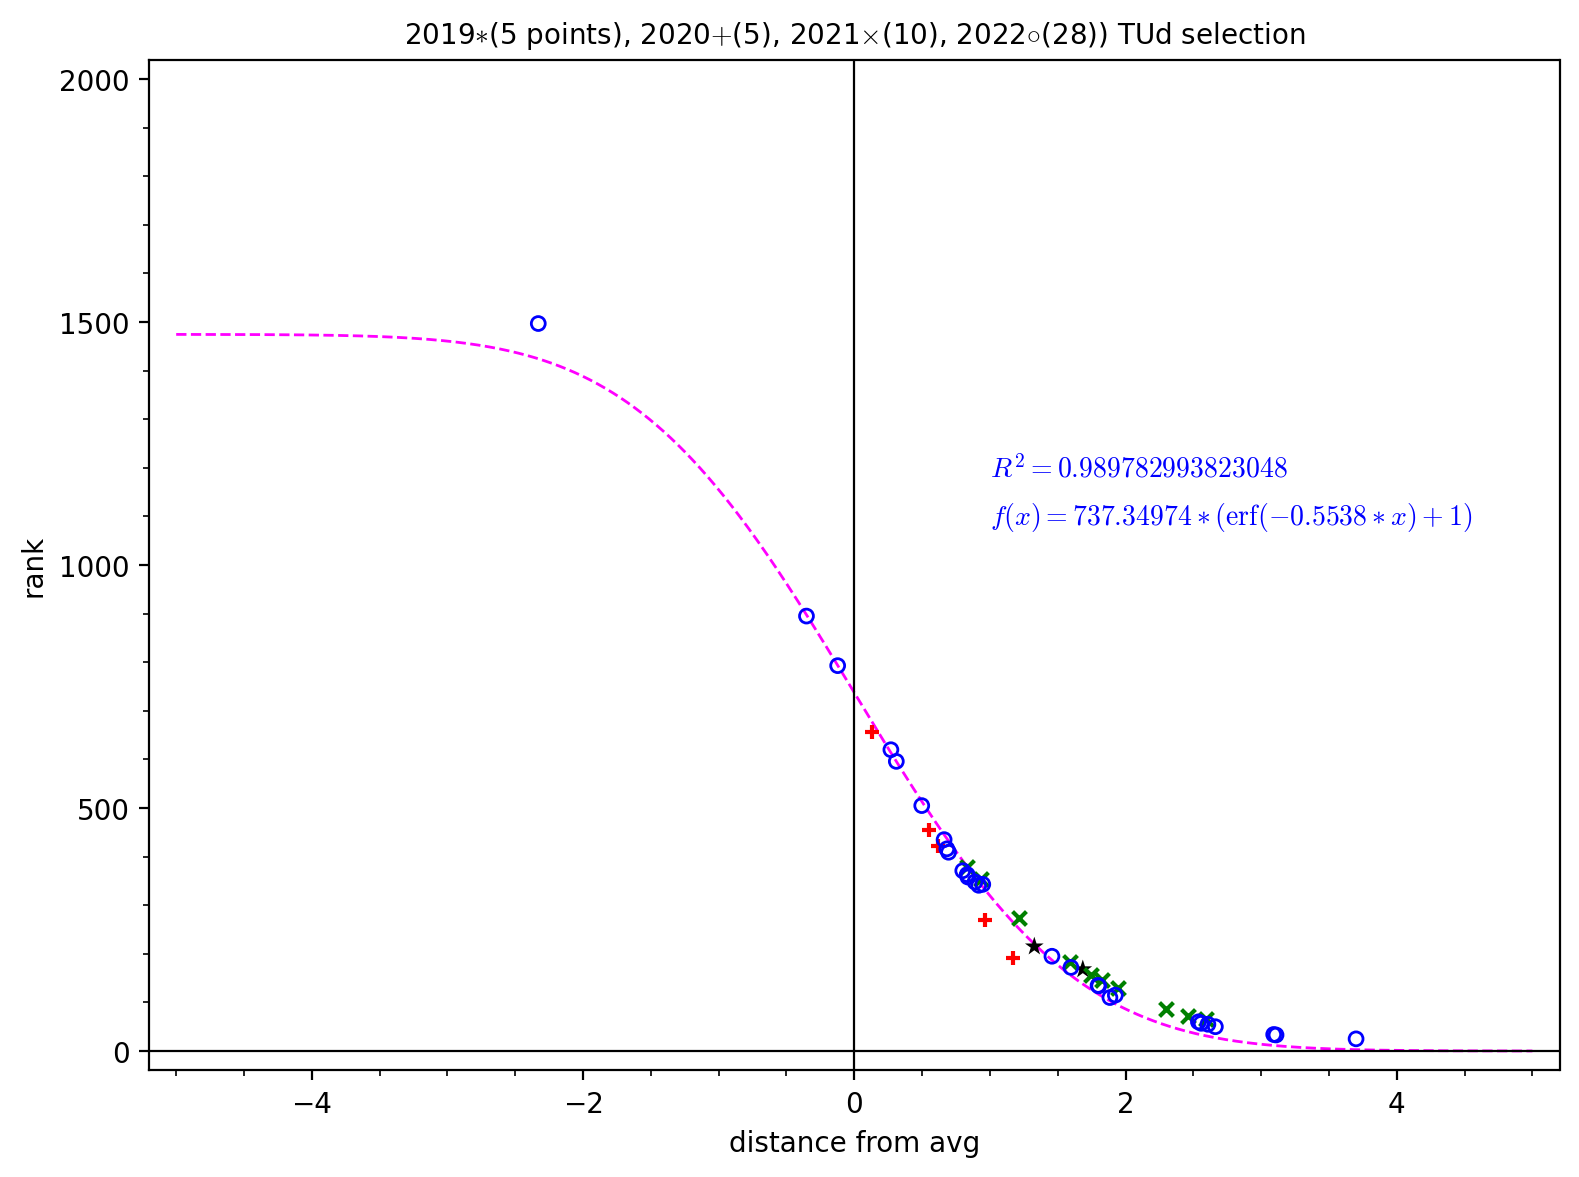

In [10]:
#| fig-format: pdf
labels = ["distance from avg","rank"]
combined = \
    scatter_plot(
        year(2019),
        marker="*",
        facecolor="black",
        edgecolor="none",
        markersize=50,
        axes_labels=labels
    ) + \
    scatter_plot(
        year(2020),
        marker="+",
        facecolor="red",
        edgecolor="none",
        markersize=25,
        axes_labels=labels
    ) + \
    scatter_plot(
        year(2021),
        marker="x",
        facecolor="green",
        edgecolor="none",
        markersize=25,
        axes_labels=labels
    ) + \
    scatter_plot(
        year(2022),
        marker="o",
        facecolor="none",
        edgecolor="blue",
        markersize=25,
        axes_labels=labels
    ) + \
    plot(
        model.subs(old_fit)(x),
        (x,-5,5),
        linestyle="--",
        color="magenta"
    ) + \
    text(
        f"$R^2 = {r2_score(current_data[:,1],list(map(model.subs(old_fit),current_data[:,0])))}$",
        (1,1200),
        horizontal_alignment="left"
    ) + \
    text(
        f"$f(x)={print_model(old_fit)}$",
        (1,1100),
        horizontal_alignment="left"
    )
combined.set_axes_range(xmin=-5, xmax=5,ymin=0,ymax=2000)
combined.show(
    title=f"2019$*$({len(year(2020))} points), 2020$+$({len(year(2020))}), 2021$\\times$({len(year(2021))}), 2022$\\circ$({len(year(2022))})) TUd selection",
    frame=True,
    dpi=200,
    figsize=8,
    axes_labels_size=1
)

This model seemed to be accurate to within 40 ranks when tried with data not included in the training set.

This model will be inaccurate when applied blindly to 2023 ranks, due to higher amount of people applying, thus lowest rank would be higher. To have a rough idea of the landscape in 2023, we scale the model by increasing the first coefficient by the factor expected.

The ceiling (i.e the lowest rank) for 2022 was 1600. We had naively eyeballed that about 1.2-1.4 times as much people would apply this year (without any backing evidence). Thus, scaling the function respectively (by a factor of 1.3) would yield

In [11]:
predicted_fit = old_fit.copy()
predicted_fit[0] = (a == predicted_fit[0].rhs()*1.3)

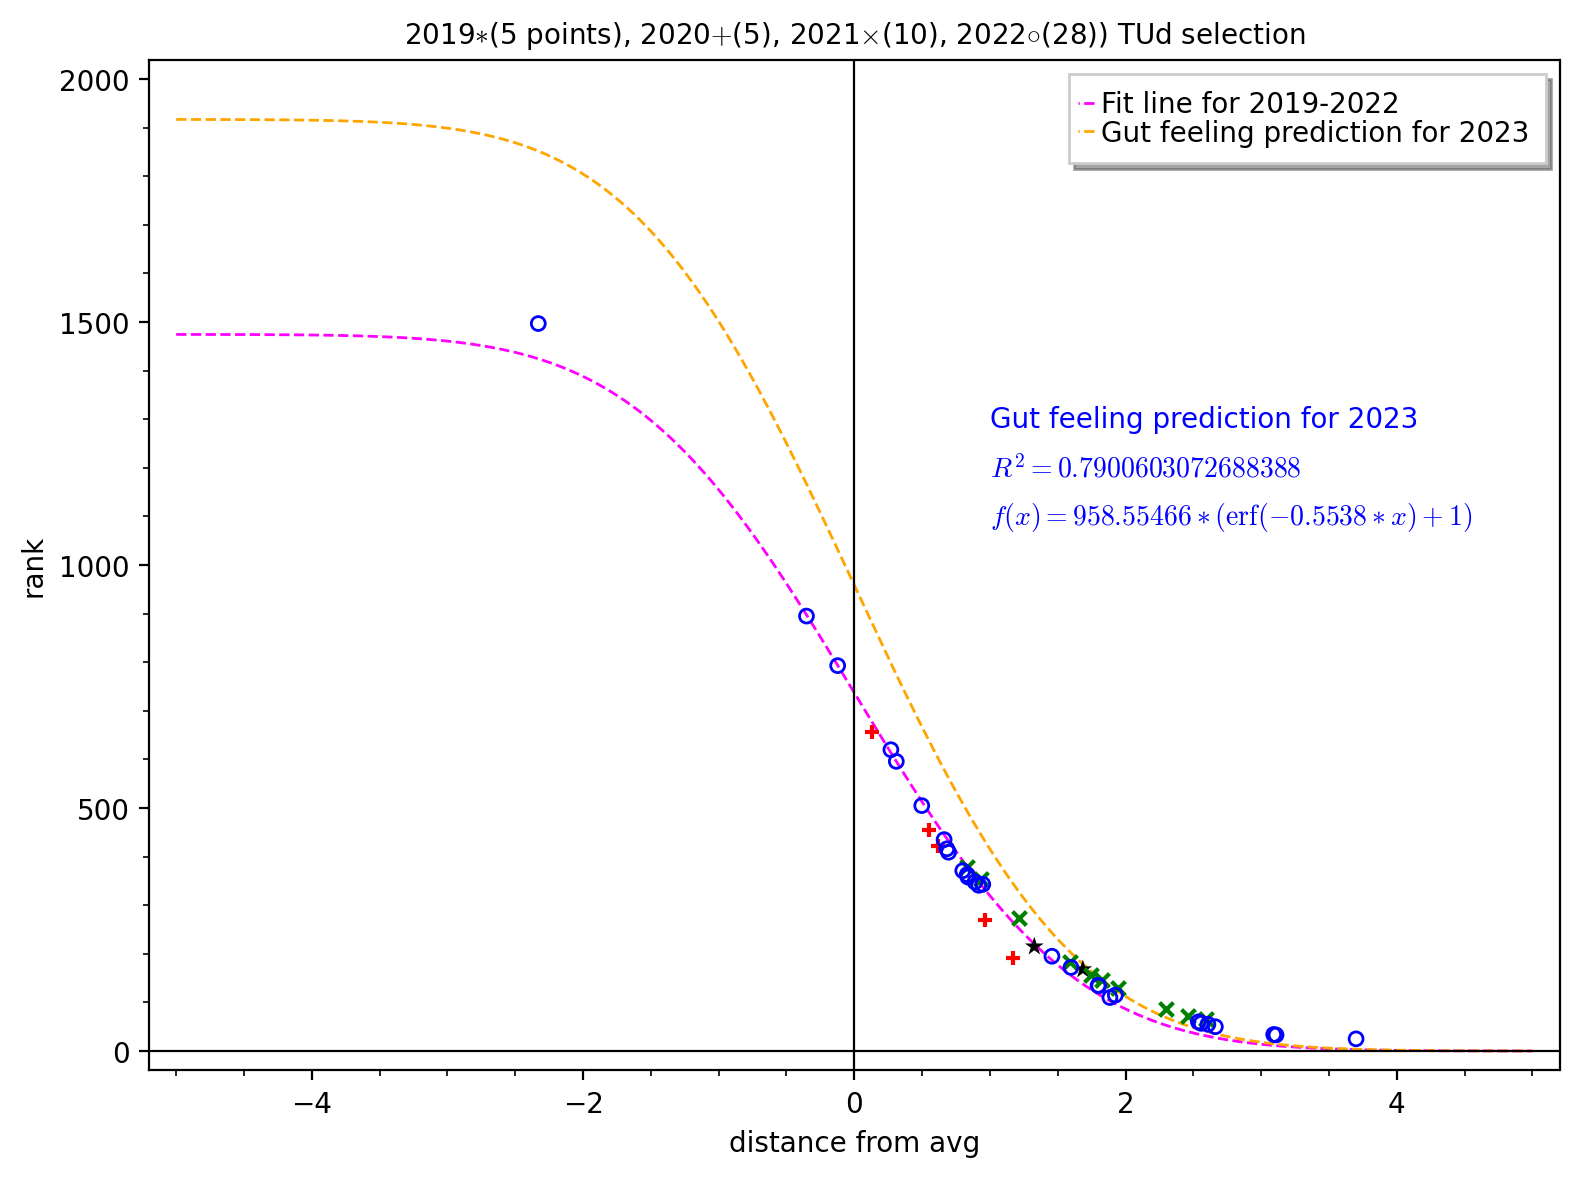

In [12]:
labels = ["distance from avg","rank"]
combined = \
    scatter_plot(
        year(2019),
        marker="*",
        facecolor="black",
        edgecolor="none",
        markersize=50,
        axes_labels=labels
    ) + \
    scatter_plot(
        year(2020),
        marker="+",
        facecolor="red",
        edgecolor="none",
        markersize=25,
        axes_labels=labels
    ) + \
    scatter_plot(
        year(2021),
        marker="x",
        facecolor="green",
        edgecolor="none",
        markersize=25,
        axes_labels=labels
    ) + \
    scatter_plot(
        year(2022),
        marker="o",
        facecolor="none",
        edgecolor="blue",
        markersize=25,
        axes_labels=labels
    ) + \
    plot(
        model.subs(old_fit)(x),
        (x,-5,5),
        linestyle="--",
        color="magenta",
        legend_label="Fit line for 2019-2022"
    ) + \
    plot(
        model.subs(predicted_fit)(x),
        (x,-5,5),
        linestyle="--",
        color="orange",
        legend_label="Gut feeling prediction for 2023"
    ) + \
    text(
        "Gut feeling prediction for 2023",
        (1,1300),
        horizontal_alignment="left"
    ) + \
    text(
        f"$R^2 = {r2_score(current_data[:,1],list(map(model.subs(predicted_fit),current_data[:,0])))}$",
        (1,1200),
        horizontal_alignment="left"
    ) + \
    text(
        f"$f(x)={print_model(predicted_fit)}$",
        (1,1100),
        horizontal_alignment="left"
    )
combined.set_axes_range(xmin=-5, xmax=5,ymin=0,ymax=2000)
combined.show(
    title=f"2019$*$({len(year(2020))} points), 2020$+$({len(year(2020))}), 2021$\\times$({len(year(2021))}), 2022$\\circ$({len(year(2022))})) TUd selection",
    frame=True,
    dpi=200,
    figsize=8,
    axes_labels_size=1
)

# Data for 2023

## Data collection
Spamed google form <https://forms.gle/tzp7KgC5CznU8Q7VA> at the TU Delft discords, and also the whatsapp chat for 2023 applicants. Apologies for the annoyance.

I am willing to say it paid off, because as of 2023-04-16, there are 92 responses (some of which were unusable due to trolling and/or invalid entries), which is great. Thanks to everyone who participated and donated data. I wish i could credit everyone individually. The persons who included their name will be in the thanks section.

## Analysis

Same as the previous section, data is different while the code is identical.

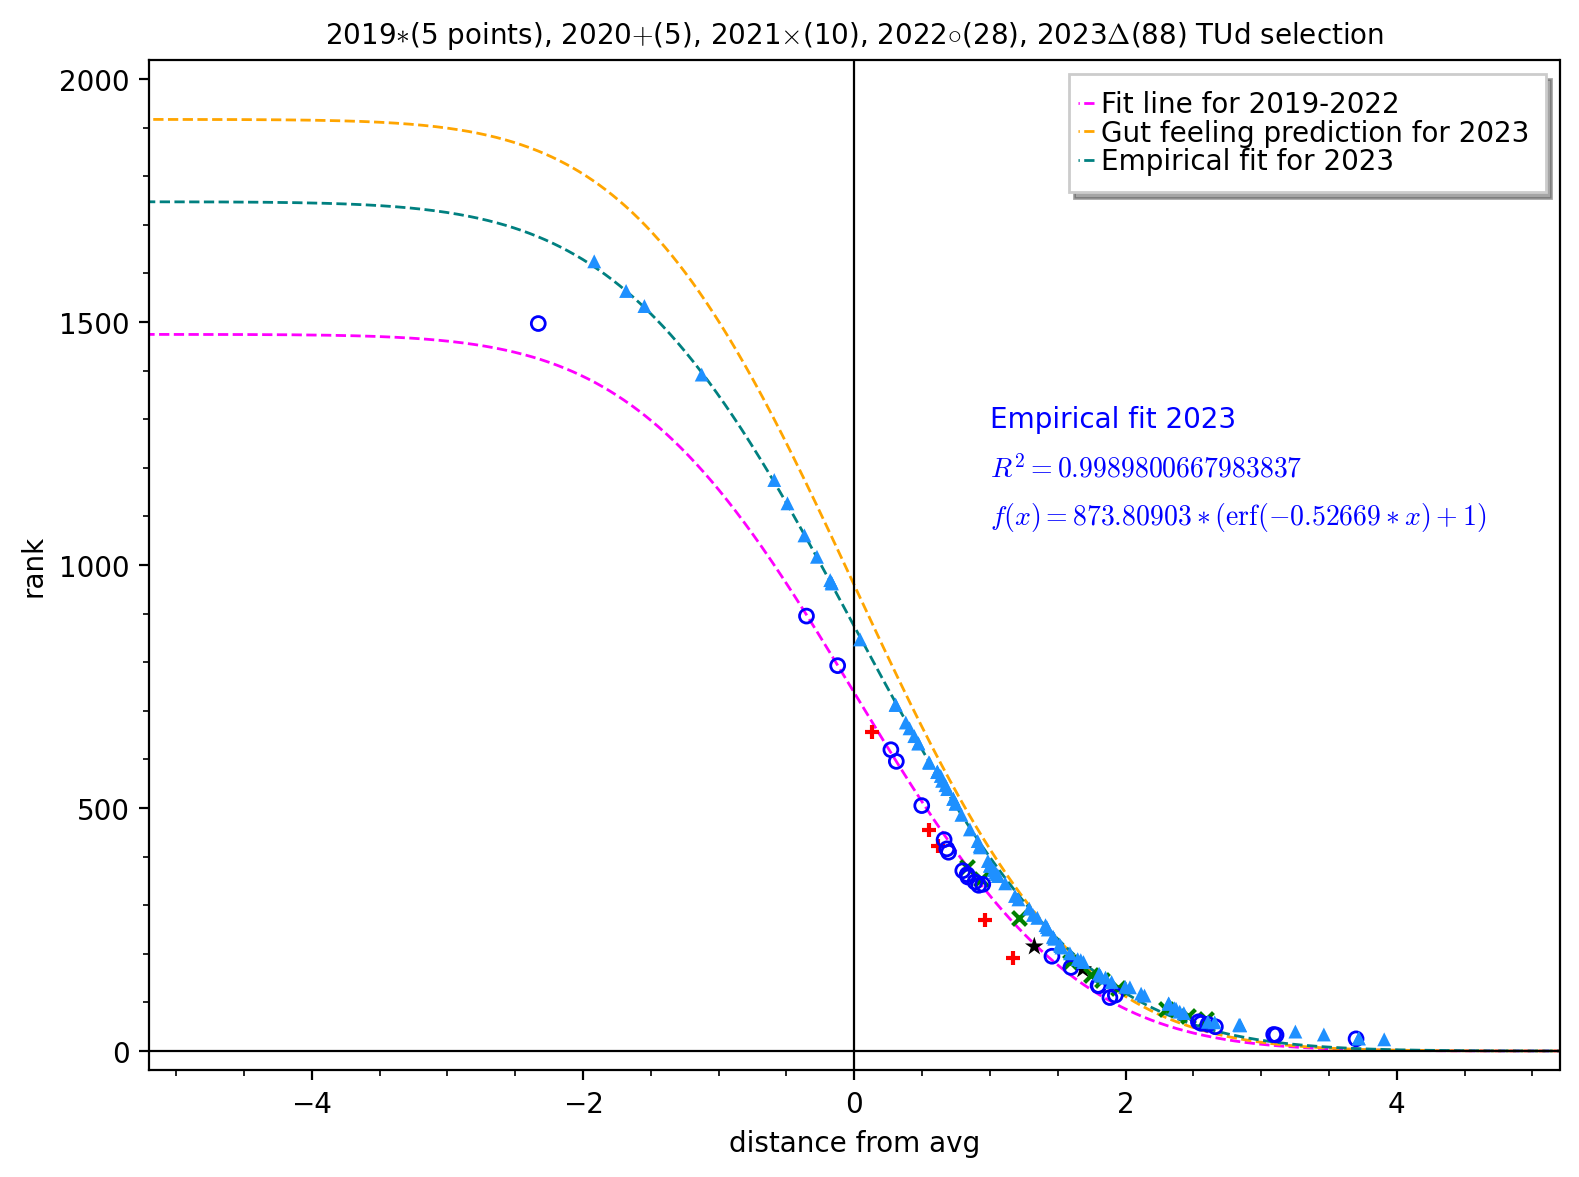

In [13]:
fit2023 = fit_to_year(year(2023))
current_data = year(2023)
combined = \
    scatter_plot(
        year(2019),
        marker="*",
        facecolor="black",
        edgecolor="none",
        markersize=50,
        axes_labels=["distance from avg","rank"],
    ) + \
    scatter_plot(
        year(2020),
        marker="+",
        facecolor="red",
        edgecolor="none",
        markersize=25,
        axes_labels=["distance from avg","rank"]
    ) + \
    scatter_plot(
        year(2021),
        marker="x",
        facecolor="green",
        edgecolor="none",
        markersize=25,
        axes_labels=["distance from avg","rank"]
    ) + \
    scatter_plot(
        year(2022),
        marker="o",
        facecolor="none",
        edgecolor="blue",
        markersize=25,
        axes_labels=["distance from avg","rank"]
    ) + \
    scatter_plot(
        year(2023),
        marker="^",
        facecolor="dodgerblue",
        edgecolor="none",
        markersize=25,
        axes_labels=["distance from avg","rank"]
    ) + \
    plot(
        model.subs(old_fit)(x),
        (x,-15,15),
        linestyle="--",
        color="magenta",
        legend_label="Fit line for 2019-2022"
    ) + \
    plot(
        model.subs(predicted_fit)(x),
        (x,-15,15),
        linestyle="--",
        color="orange",
        legend_label="Gut feeling prediction for 2023"
    ) + \
    plot(
        model.subs(fit2023)(x),
        (x,-15,15),
        linestyle="--",
        color="teal",
        legend_label="Empirical fit for 2023"
    ) + \
    text(
        "Empirical fit 2023",
        (1,1300),
        horizontal_alignment="left"
    ) + \
    text(
        f"$R^2 = {r2_score(current_data[:,1],list(map(model.subs(fit2023),current_data[:,0])))}$",
        (1,1200),
        horizontal_alignment="left"
    ) + \
    text(
        f"$f(x)={print_model(fit2023)}$",
        (1,1100),
        horizontal_alignment="left"
    )
combined.set_axes_range(xmin=-5, xmax=5,ymin=0,ymax=2000)
combined.show(
    title=f"2019$*$({len(year(2020))} points), 2020$+$({len(year(2020))}), 2021$\\times$({len(year(2021))}), 2022$\\circ$({len(year(2022))}), 2023$\Delta$({len(year(2023))}) TUd selection",
    frame=True,
    dpi=200,
    figsize=8,
    axes_labels_size=1
)

# Playing around
Now that i knew the fit line for 2023, i had a rough idea how many more people applied.

My fit for 2019-2022 yielded 

In [14]:
model.subs(old_fit)(-999)

1474.6994782364534

as the lowest rank.

The e-mail sent last year showed that 2300 people applied and about 1800 finished the mini-mooc. I suspect that some people dropped after that as well, however a drop of

In [15]:
1800 - _

325.3005217635466

seems a little too much.

Yet still, let us asssume this number is correct for now.

The highest rank yielded by the 2023 fit is

In [16]:
model.subs(fit2023)(-999)

1747.6180518955043

If we are to assume this number is correct,

In [17]:
_16 / _14

1.1850672477252284

times as much people applied.

My eyeball estimation was 1.3 times. Instead if my naive prediction had used the number above as the coefficient, the following line would appear

In [18]:
predicted_fit = old_fit.copy()
predicted_fit[0] = (a == predicted_fit[0].rhs()*_17)

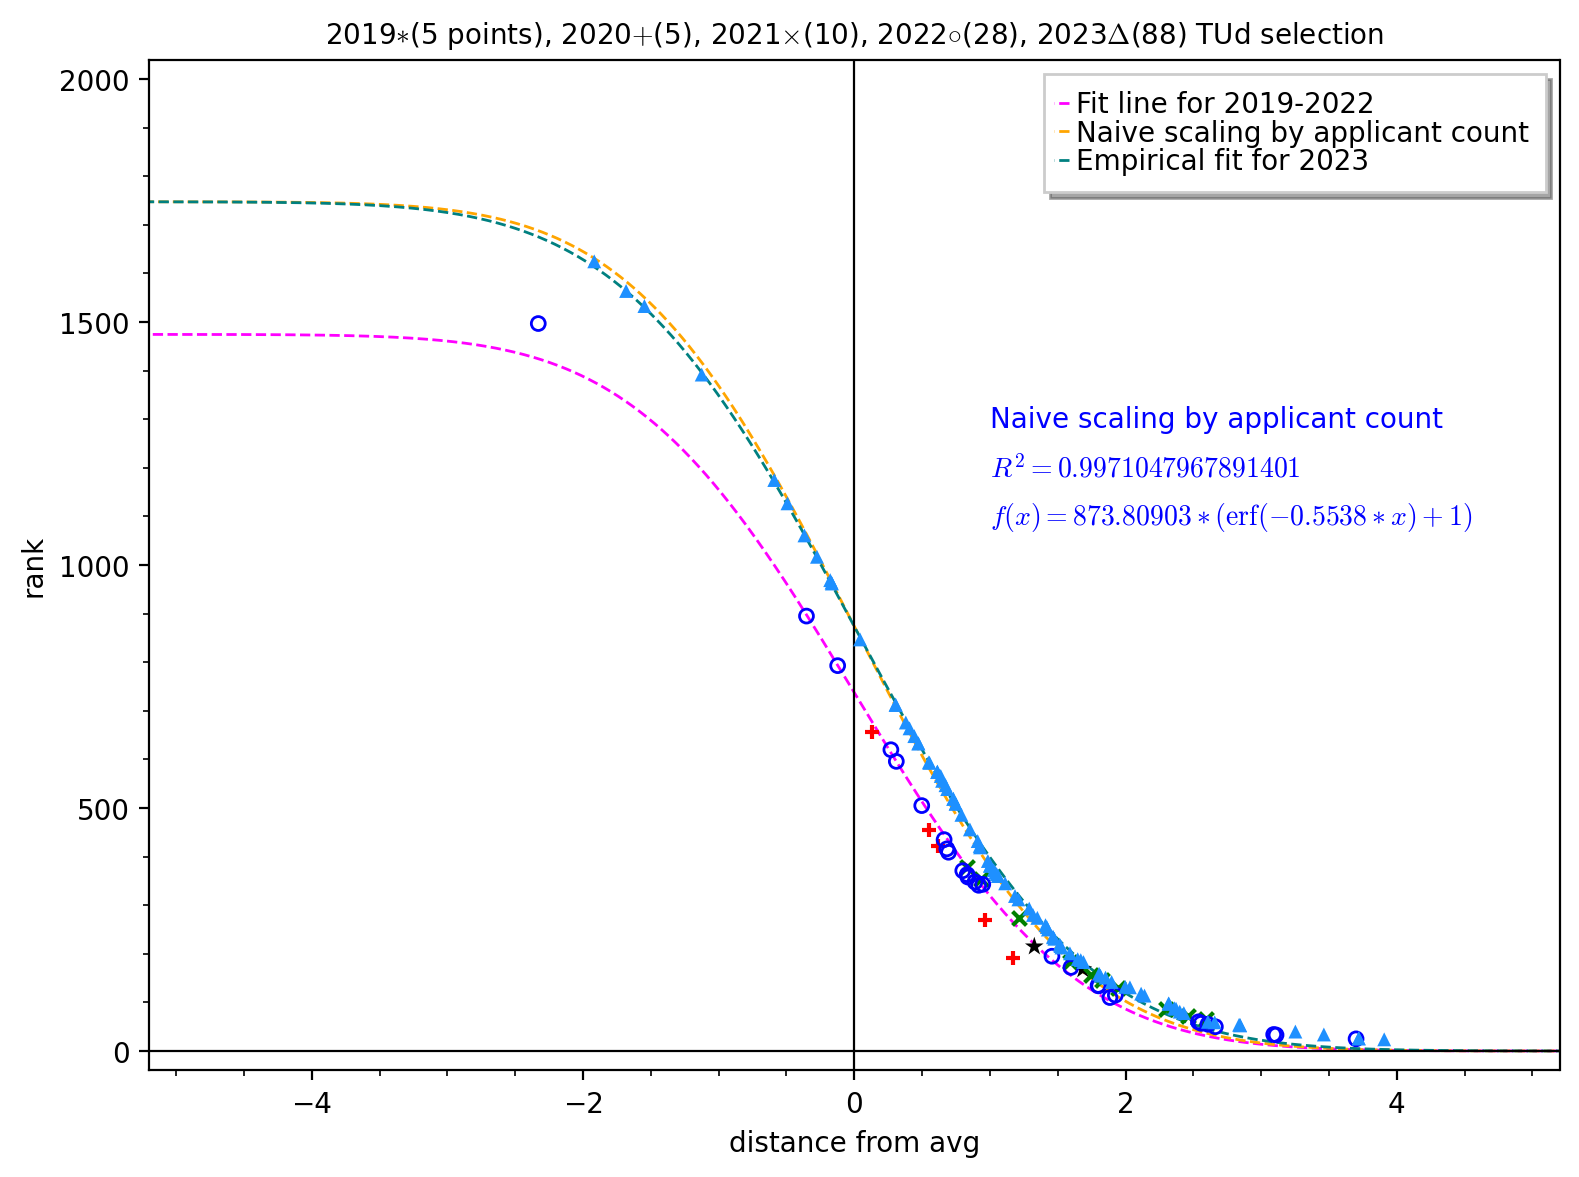

In [19]:
fit2023 = fit_to_year(year(2023))
current_data = year(2023)
combined = \
    scatter_plot(
        year(2019),
        marker="*",
        facecolor="black",
        edgecolor="none",
        markersize=50,
        axes_labels=["distance from avg","rank"],
    ) + \
    scatter_plot(
        year(2020),
        marker="+",
        facecolor="red",
        edgecolor="none",
        markersize=25,
        axes_labels=["distance from avg","rank"]
    ) + \
    scatter_plot(
        year(2021),
        marker="x",
        facecolor="green",
        edgecolor="none",
        markersize=25,
        axes_labels=["distance from avg","rank"]
    ) + \
    scatter_plot(
        year(2022),
        marker="o",
        facecolor="none",
        edgecolor="blue",
        markersize=25,
        axes_labels=["distance from avg","rank"]
    ) + \
    scatter_plot(
        year(2023),
        marker="^",
        facecolor="dodgerblue",
        edgecolor="none",
        markersize=25,
        axes_labels=["distance from avg","rank"]
    ) + \
    plot(
        model.subs(old_fit)(x),
        (x,-15,15),
        linestyle="--",
        color="magenta",
        legend_label="Fit line for 2019-2022"
    ) + \
    plot(
        model.subs(predicted_fit)(x),
        (x,-15,15),
        linestyle="--",
        color="orange",
        legend_label="Naive scaling by applicant count"
    ) + \
    plot(
        model.subs(fit2023)(x),
        (x,-15,15),
        linestyle="--",
        color="teal",
        legend_label="Empirical fit for 2023"
    ) + \
    text(
        "Naive scaling by applicant count",
        (1,1300),
        horizontal_alignment="left"
    ) + \
    text(
        f"$R^2 = {r2_score(current_data[:,1],list(map(model.subs(predicted_fit),current_data[:,0])))}$",
        (1,1200),
        horizontal_alignment="left"
    ) + \
    text(
        f"$f(x)={print_model(predicted_fit)}$",
        (1,1100),
        horizontal_alignment="left"
    )
combined.set_axes_range(xmin=-5, xmax=5,ymin=0,ymax=2000)
combined.show(
    title=f"2019$*$({len(year(2020))} points), 2020$+$({len(year(2020))}), 2021$\\times$({len(year(2021))}), 2022$\\circ$({len(year(2022))}), 2023$\Delta$({len(year(2023))}) TUd selection",
    frame=True,
    dpi=200,
    figsize=8,
    axes_labels_size=1
)

# Conclusion

Predicting rank using this methodology, i.e getting the last year's curve and scaling it proportionally to this year's applicant count, seems to work reliable enough for estimating whether one gets in or not.

The greatest limiting factor in applying this method to future years would be the fact that the applicant counts are not released, makes this method rather inaccurate.